# Stroke Data Exploration

Obtained from kaggle: https://www.kaggle.com/fedesoriano/stroke-prediction-dataset

In [71]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV

## Read & Survey Data

First, we will read in our dataset and gain some high-level information, such as number of features present, and percentage of positive labels.

**NB** The following cells assume the dataset has been downloaded and extracted to `data/`.

In [72]:
# Read in dataset csv
stroke_df = pd.read_csv('data/healthcare-dataset-stroke-data.csv')

In [73]:
stroke_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [74]:
num_strokes = len(stroke_df[stroke_df['stroke'] == 1])
total_rows = len(stroke_df)
print('Number of rows in dataset: ' + str(total_rows))
print('Percentage of strokes in dataset: ' + str(round((num_strokes / total_rows),3)) + '%')

Number of rows in dataset: 5110
Percentage of strokes in dataset: 0.049%


In [75]:
stroke_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


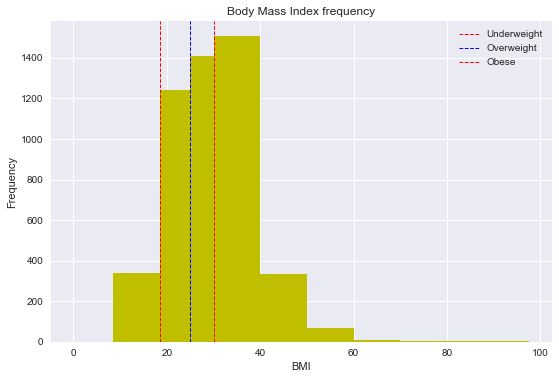

In [76]:
# Exploratory Visualisation
x = stroke_df['bmi']

plt.hist(x, bins=[0, 8.5, 18.5, 25, 30, 40, 50, 60, 70, x.max()], color='y')
plt.title('Body Mass Index frequency')
plt.axvline(18.5, color='r', linestyle='dashed', linewidth=1, label='Underweight')
plt.axvline(25, color='b', linestyle='dashed', linewidth=1, label='Overweight')
plt.axvline(30, color='r', linestyle='dashed', linewidth=1, label='Obese')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('images/bmi_hist.png')
plt.show()

In [77]:
# How much of our dataset has a healthy BMI
healthy_bmis = np.array(x.where((x > 18.5) & (x < 25)))

print('Healthy BMIs in dataset: ' + str(np.round(100*len(healthy_bmis[np.logical_not(np.isnan(healthy_bmis))]) / len(x), 3)) + '%')

# How much of our dataset are obese according to BMI
obese_bmis = np.array(x.where(x > 30))

print('Obese BMIs in dataset: ' + str(np.round(100*len(obese_bmis[np.logical_not(np.isnan(obese_bmis))]) / len(x), 3)) + '%')

Healthy BMIs in dataset: 24.09%
Obese BMIs in dataset: 37.045%


## Data Preprocessing

### Deal with nulls

In the output of the previous cell, we see that all features except `bmi` are free of nulls.

We're going to relace these values with the median value for `bmi`.

In [78]:
print(stroke_df.isnull().sum())
print(stroke_df.shape)
print('Maximum percentage of rows with null values in dataset: ' + str(round(100 * stroke_df.isnull().sum().sum() / len(stroke_df), 3)) + '%')

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64
(5110, 12)
Maximum percentage of rows with null values in dataset: 3.933%


In [79]:
stroke_df['bmi'] = stroke_df['bmi'].replace(np.NaN, stroke_df['bmi'].median())
print(stroke_df.isnull().sum())
print(stroke_df.shape)

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64
(5110, 12)


### One hot encoding

In [80]:
str_cols = list(stroke_df.dtypes[stroke_df.dtypes == 'object'].index)

stroke_df = pd.get_dummies(stroke_df, columns=str_cols)

### Split data

In [81]:
x = stroke_df.drop(columns=['stroke'],axis=1, inplace=False)
y = stroke_df['stroke']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [82]:
y_train

3378    0
479     0
3683    0
2997    0
286     0
       ..
4426    0
466     0
3092    0
3772    0
860     0
Name: stroke, Length: 3423, dtype: int64

## Benchmark Model

### Linear Regression

In [83]:
model = LogisticRegression(solver='liblinear', random_state=0)

In [84]:
x_train

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,gender_Other,ever_married_No,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
3378,62090,51.00,0,0,219.17,29.8,0,1,0,1,...,0,0,1,0,1,0,0,0,1,0
479,15649,54.00,1,0,198.69,28.1,0,1,0,0,...,0,1,0,0,1,0,0,0,0,1
3683,27647,80.00,0,1,95.49,31.6,0,1,0,0,...,0,0,1,0,1,0,1,0,0,0
2997,4498,71.00,0,1,204.98,28.1,0,1,0,0,...,0,1,0,0,0,1,0,1,0,0
286,36811,23.00,0,0,94.09,30.9,1,0,0,1,...,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4426,13846,43.00,0,0,88.00,30.6,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
466,1307,61.00,1,0,170.05,60.2,1,0,0,0,...,0,1,0,0,1,0,0,0,0,1
3092,31481,1.16,0,0,97.28,17.8,1,0,0,1,...,0,0,0,1,0,1,1,0,0,0
3772,61827,80.00,0,0,196.08,31.0,0,1,0,0,...,0,0,1,0,1,0,0,1,0,0


In [85]:
model.fit(x_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [86]:
model.predict(x_test)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [87]:
model.score(x_test, y_test)

0.942501481920569

In [88]:
matrix = confusion_matrix(y_test, model.predict(x_test))
print(matrix)

[[1589    2]
 [  95    1]]


In [89]:
recall = matrix[1][1] / (matrix[1][1] + matrix[1][0])
print('Recall score: ' + str(round(recall, 4)))

precision = matrix[1][1] / (matrix[1][1] + matrix[0][1])
print('Precision score: ' + str(round(precision, 4)))

f1 = (2 * precision * recall / (precision + recall))
print('F1 score: ' + str(round(f1, 4)))

Recall score: 0.0104
Precision score: 0.3333
F1 score: 0.0202


### Improve the Model

In [90]:
model = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=0)
model.fit(x_train, y_train)

LogisticRegression(class_weight='balanced', random_state=0, solver='liblinear')

In [91]:
matrix = confusion_matrix(y_test, model.predict(x_test))
print(matrix)

[[1178  413]
 [  24   72]]


In [92]:
recall = matrix[1][1] / (matrix[1][1] + matrix[1][0])
print('Recall score: ' + str(round(recall, 4)))

precision = matrix[1][1] / (matrix[1][1] + matrix[0][1])
print('Precision score: ' + str(round(precision, 4)))

f1 = (2 * precision * recall / (precision + recall))
print('F1 score: ' + str(round(f1, 4)))

Recall score: 0.75
Precision score: 0.1485
F1 score: 0.2478


In [93]:
model.get_params()

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 0,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

### Using Grid Search

In [94]:
lr = LogisticRegression()             # initialize the model

#solver_options = ['newton-cg', 'lbfgs', 'liblinear', 'sag']
solver_options = ['newton-cg']
#multi_class_options = ['ovr', 'multinomial']
#class_weight_options = ['None', 'balanced']
multi_class_options = ['ovr']
class_weight_options = ['balanced']
max_iter_value = [10000]
c_values = [1, 10, 100, 1000]

param_grid = dict(solver = solver_options, multi_class = multi_class_options, class_weight = class_weight_options, max_iter = max_iter_value, C = c_values)

grid = GridSearchCV(lr, param_grid, scoring = 'f1', n_jobs=-1)
grid.fit(x_train, y_train)

C:\Users\eogha\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\eogha\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\eogha\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\eogha\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\eogha\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000], 'class_weight': ['balanced'],
                         'max_iter': [10000], 'multi_class': ['ovr'],
                         'solver': ['newton-cg']},
             scoring='f1')

In [95]:
grid.best_estimator_

LogisticRegression(C=10, class_weight='balanced', max_iter=10000,
                   multi_class='ovr', solver='newton-cg')

In [96]:
matrix = confusion_matrix(y_test, grid.best_estimator_.predict(x_test))
print(matrix)

recall = matrix[1][1] / (matrix[1][1] + matrix[1][0])
print('Recall score: ' + str(round(recall, 4)))

precision = matrix[1][1] / (matrix[1][1] + matrix[0][1])
print('Precision score: ' + str(round(precision, 4)))

f1 = (2 * precision * recall / (precision + recall))
print('F1 score: ' + str(round(f1, 4)))

[[1179  412]
 [  23   73]]
Recall score: 0.7604
Precision score: 0.1505
F1 score: 0.2513


### Rebalancing dataset

In [97]:
# TBC